In [1]:
!nvidia-smi

Thu Dec 14 15:01:25 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.90                 Driver Version: 384.90                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:04:00.0 Off |                  N/A |
| 27%   27C    P8     9W / 180W |     10MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:05:00.0 Off |                  N/A |
| 27%   29C    P8     9W / 180W |     10MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
%matplotlib inline
################################################################################
import os
import numpy as np
import pandas as pd
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import matplotlib.pyplot as plt
import theano
import theano.tensor as T
import keras
import keras.backend as K
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense, GRU, Flatten, TimeDistributed, Dropout
from keras.layers import Bidirectional
from typing import Tuple, Callable, List, Optional, Sequence, Generator, Any
from tracker import visuals, extractor, utils, metrics

np.set_printoptions(suppress=True, precision=2)
np.set_printoptions(edgeitems=20)
Tensor = theano.tensor.Tensor

Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:04:00.0)
Using Theano backend.


In [3]:
################################################################################
def get_data(
        num_vectors : int,
        vector_size : int = 3,
        min_value   : int = 0,
        max_value   : int = 9,
        ) -> np.ndarray:
    return np.random.randint(min_value, max_value, (num_vectors, vector_size))

def get_output(data: np.ndarray) -> np.ndarray:
    """
    Create a 1-hot categorical matrix from *data*.
    *data* is a 2D array. Create output array by:
    For each cell in *data*, transform to 1 if cell is even. Else, 0.
    For each row, concatenate all the 1s and 0s into a single binary number.
    The binary number corresponds to that row's category.
    Example: If row = (2, 4, 80), then category = 000 = 0.
    Example: If row = (1, 30, 9), then category = 101 = 5.
    Example: If row = (3, 9, 12, 7), then category = 1101 = 13.
    Example: If row = (2, 1), then category = 01 = 1.
    """
    weights = np.array([2**i for i in range(data.shape[1])])[::-1]
    output = np.zeros((len(data), 2**len(weights)))
    indices = (data % 2) @ weights
    output[np.arange(len(data)), indices] = 1
    return output

np.random.seed(1010)
data   = np.array([get_data(num_vectors=6) for _ in range(1024)])
output = np.array([get_output(matrix) for matrix in data])
val_data   = np.array([get_data(num_vectors=6) for _ in range(512)])
val_output = np.array([get_output(matrix) for matrix in val_data])
print("=== Input Matrix ===\n{0}\n{1}".format(data.shape, data))
print("\n=== Output Matrix ===\n{0}\n{1}".format(output.shape, output))

=== Input Matrix ===
(1024, 6, 3)
[[[4 8 2]
  [5 3 6]
  [2 1 5]
  [0 6 8]
  [1 8 0]
  [1 5 7]]

 [[6 3 8]
  [3 5 8]
  [6 2 5]
  [2 5 1]
  [7 1 5]
  [0 1 0]]

 [[1 3 8]
  [8 8 8]
  [8 7 3]
  [6 2 3]
  [4 6 0]
  [4 7 2]]

 [[4 8 1]
  [1 7 1]
  [1 8 7]
  [1 2 1]
  [7 7 4]
  [5 3 5]]

 [[5 6 6]
  [8 0 0]
  [2 7 7]
  [6 1 3]
  [6 5 8]
  [1 2 6]]

 [[5 5 5]
  [0 1 7]
  [5 0 4]
  [5 3 7]
  [4 8 6]
  [3 5 5]]

 [[2 6 7]
  [0 8 6]
  [5 2 0]
  [4 3 8]
  [5 7 2]
  [3 6 6]]

 [[2 2 7]
  [7 2 8]
  [0 0 8]
  [1 1 8]
  [0 8 8]
  [0 3 3]]

 [[2 0 6]
  [3 6 4]
  [2 5 0]
  [5 0 7]
  [5 5 4]
  [0 8 6]]

 [[0 4 2]
  [5 2 8]
  [8 7 1]
  [1 8 2]
  [0 8 2]
  [0 5 4]]

 [[8 6 4]
  [7 2 1]
  [1 8 0]
  [2 1 3]
  [0 6 3]
  [7 7 2]]

 [[4 1 4]
  [4 3 6]
  [2 8 7]
  [7 4 2]
  [0 3 0]
  [4 1 2]]

 [[5 6 2]
  [7 6 5]
  [5 8 8]
  [7 6 6]
  [8 3 7]
  [2 2 6]]

 [[7 8 4]
  [7 2 2]
  [2 1 0]
  [1 7 1]
  [6 5 0]
  [2 8 8]]

 [[6 4 8]
  [3 5 8]
  [8 2 2]
  [4 6 7]
  [4 2 5]
  [3 0 3]]

 [[8 5 3]
  [7 6 6]
  [7 5 4]
  [5 7

### Loss is purely the built-in categorical cross_entropy

In [4]:
################################################################################
input_layer  = Input(name="Input", shape=data.shape[1:])
model_layer  = Dropout(name="Dropout 1", rate=1/2)(input_layer)
model_layer  = Bidirectional(GRU(name="GRU 1", units=512, return_sequences=True,
                    recurrent_dropout=1/2, implementation=2))(model_layer)
model_layer  = keras.layers.BatchNormalization()(model_layer)
model_layer  = Dropout(name="Dropout 2", rate=1/2)(model_layer)
model_layer  = Bidirectional(GRU(name="GRU 2", units=512, return_sequences=True,
                   recurrent_dropout=1/2, implementation=2))(model_layer)
model_layer  = Dropout(name="Dropout 3", rate=1/2)(model_layer)
model_layer  = Bidirectional(GRU(name="GRU 3", units=512, return_sequences=True,
                   recurrent_dropout=1/2, implementation=2))(model_layer)
output_layer = Dense(name="Output", units=output.shape[2], activation="softmax")(model_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss="categorical_crossentropy", optimizer="adadelta", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 6, 3)              0         
_________________________________________________________________
Dropout 1 (Dropout)          (None, 6, 3)              0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 6, 1024)           1585152   
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 1024)           4096      
_________________________________________________________________
Dropout 2 (Dropout)          (None, 6, 1024)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 6, 1024)           4721664   
_________________________________________________________________
Dropout 3 (Dropout)          (None, 6, 1024)           0         
__________

In [5]:
%%time
################################################################################
np.random.seed(1010)
histories = model.fit(data, output, epochs=64, batch_size=1, verbose=2,
                      validation_data=(val_data, val_output))

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


Train on 1024 samples, validate on 512 samples
Epoch 1/64
33s - loss: 2.3315 - acc: 0.1326 - val_loss: 2.3062 - val_acc: 0.1367
Epoch 2/64
33s - loss: 2.1819 - acc: 0.1392 - val_loss: 2.1112 - val_acc: 0.1429
Epoch 3/64
33s - loss: 2.0950 - acc: 0.1603 - val_loss: 2.0862 - val_acc: 0.1602
Epoch 4/64
33s - loss: 2.0760 - acc: 0.1646 - val_loss: 2.0681 - val_acc: 0.1813
Epoch 5/64
33s - loss: 2.0700 - acc: 0.1699 - val_loss: 2.0663 - val_acc: 0.1696
Epoch 6/64
33s - loss: 2.0690 - acc: 0.1670 - val_loss: 2.0685 - val_acc: 0.1800
Epoch 7/64
33s - loss: 2.0665 - acc: 0.1654 - val_loss: 2.0804 - val_acc: 0.1426
Epoch 8/64
33s - loss: 2.0697 - acc: 0.1701 - val_loss: 2.0625 - val_acc: 0.1859
Epoch 9/64
33s - loss: 2.0682 - acc: 0.1644 - val_loss: 2.0572 - val_acc: 0.1855
Epoch 10/64
32s - loss: 2.0704 - acc: 0.1673 - val_loss: 2.0666 - val_acc: 0.1527
Epoch 11/64
32s - loss: 2.0687 - acc: 0.1691 - val_loss: 2.0721 - val_acc: 0.1458
Epoch 12/64
32s - loss: 2.0699 - acc: 0.1639 - val_loss: 2.0

In [1]:
################################################################################
plt.plot(histories.history['loss'])
plt.plot(histories.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.plot(histories.history['acc'])
plt.plot(histories.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

NameError: name 'plt' is not defined

In [12]:
################################################################################
test_input  = val_data
test_output = val_output
predictions = model.predict(test_input).round(2)
print("\nAvg Difference: {}".format(np.abs(test_output - predictions).mean()))
print("=== Input ===\n{}".format(test_input))
print("\n=== True Output ===\n{}".format(test_output))
print("\n=== Prediction ===\n{}".format(predictions))


Avg Difference: 0.21839355287405246
=== Input ===
[[[7 0 5]
  [7 5 0]
  [0 2 3]
  [0 3 1]
  [8 8 8]
  [4 4 7]]

 [[0 3 5]
  [0 4 3]
  [1 8 5]
  [6 2 4]
  [3 6 2]
  [2 3 8]]

 [[7 4 2]
  [4 1 6]
  [2 3 4]
  [6 5 5]
  [8 6 4]
  [2 3 1]]

 [[8 0 1]
  [8 0 5]
  [8 6 7]
  [2 0 2]
  [2 1 8]
  [7 3 0]]

 [[6 5 1]
  [7 4 8]
  [7 1 0]
  [8 6 8]
  [0 5 4]
  [5 3 4]]

 [[2 1 6]
  [6 8 6]
  [7 3 7]
  [4 8 1]
  [3 0 2]
  [6 2 7]]

 [[6 0 7]
  [8 1 6]
  [6 4 5]
  [8 6 2]
  [4 4 2]
  [8 2 2]]

 [[3 2 3]
  [5 4 2]
  [2 4 5]
  [7 2 6]
  [5 1 6]
  [3 5 7]]

 [[3 5 6]
  [2 5 6]
  [3 1 6]
  [4 5 5]
  [4 8 4]
  [6 4 6]]

 [[8 6 8]
  [2 6 8]
  [1 6 0]
  [4 5 1]
  [6 1 2]
  [7 3 4]]

 [[2 4 2]
  [0 7 5]
  [5 8 4]
  [3 8 3]
  [7 7 4]
  [1 1 7]]

 [[5 7 7]
  [4 8 5]
  [6 4 1]
  [7 0 0]
  [6 7 8]
  [5 1 0]]

 [[5 3 0]
  [3 8 3]
  [8 7 7]
  [8 3 7]
  [0 2 2]
  [8 1 8]]

 [[0 6 4]
  [1 3 5]
  [1 2 3]
  [1 5 6]
  [7 2 0]
  [6 0 4]]

 [[2 1 4]
  [8 8 1]
  [6 2 4]
  [0 6 3]
  [3 3 0]
  [7 8 6]]

 [[1 4 0]
  [1 0 7]

### Loss is custom and input tensor is introduced

In [8]:
################################################################################
class InputTensorLossFunction:
    def __init__(self,
            input_shape  : Tuple[int, int],
            output_shape : Tuple[int, int],
            input_tensor : Tensor,
            ) -> None:
        self.output_shape = output_shape
        self.input_shape  = input_shape
        self.input_tensor = input_tensor
    
    def exponents_of_2_tensor(self, shape: Tuple[int, int]) -> Tensor:
        """
        Return matrix with shape equal to *shape* of the form:
        [2, 4, 8, ..., 2**n]
        [2, 4, 8, ..., 2**n]
        ...
        [2, 4, 8, ..., 2**n]
        """
        m = [[2**i for i in range(shape[1])][::-1] for _ in range(shape[0])]
        return T.as_tensor(m)
    
    def make_meshgrid(self, shape: Tuple[int, int]) -> Tensor:
        """
        Create a meshgrid with shape equal to *shape*.
        Example for shape (3, 5):
            [[0, 1, 2, 3, 4],
             [0, 1, 2, 3, 4],
             [0, 1, 2, 3, 4]]
        """
        return (T.mgrid[0:shape[0], 0:shape[1]][1])
    
    def penalize_noncommitment(self, y_pred: Tensor, multiplier: float) -> Tensor:
        return multiplier * (1 - y_pred.max(-1)).sum(-1)
#         closeness_to_half = 1 - 4 * (y_pred - 0.5)**2
#         return multiplier * closeness_to_half.sum(-1).sum(-1)
        
    def __call__(self) -> Callable[[Tensor, Tensor], Tensor]:
        """ Return a loss function that is callable by keras. """
        def custom_loss(y_true: Tensor, y_pred: Tensor) -> Tensor:
            exp2 = self.exponents_of_2_tensor(self.input_shape)
            true = ((self.input_tensor % 2) * exp2).sum(-1)
            pred = (y_pred * self.make_meshgrid(self.output_shape)).sum(-1)
            return ((true - pred)**2).sum(-1)
        return custom_loss
    
A = T.dtensor3("A")
B = T.dtensor3("B")
C = T.dtensor3("C")
inputs = data[0:5]
y_true = output[0:5]
y_pred = output[0:5]
D = InputTensorLossFunction(data.shape[1:], output.shape[1:], A)()
E = D(B, C)
F = theano.function([A, B, C], E, on_unused_input="ignore")
evaluation = F(inputs, y_true, y_pred).round(2)
print("=== Input ===\n{}".format(inputs))
print("\n=== Prediction ===\n{}".format(y_pred))
print("\n=== Losses ===\n{}".format(evaluation))

=== Input ===
[[[4 8 2]
  [5 3 6]
  [2 1 5]
  [0 6 8]
  [1 8 0]
  [1 5 7]]

 [[6 3 8]
  [3 5 8]
  [6 2 5]
  [2 5 1]
  [7 1 5]
  [0 1 0]]

 [[1 3 8]
  [8 8 8]
  [8 7 3]
  [6 2 3]
  [4 6 0]
  [4 7 2]]

 [[4 8 1]
  [1 7 1]
  [1 8 7]
  [1 2 1]
  [7 7 4]
  [5 3 5]]

 [[5 6 6]
  [8 0 0]
  [2 7 7]
  [6 1 3]
  [6 5 8]
  [1 2 6]]]

=== Prediction ===
[[[ 1.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  1.  0.]
  [ 0.  0.  0.  1.  0.  0.  0.  0.]
  [ 1.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  1.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  1.]]

 [[ 0.  0.  1.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  1.  0.]
  [ 0.  1.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  1.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  1.]
  [ 0.  0.  1.  0.  0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.  0.  0.  1.  0.]
  [ 1.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  1.  0.  0.  0.  0.]
  [ 0.  1.  0.  0.  0.  0.  0.  0.]
  [ 1.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  1.  0.  0.  0.  0.  0.]]

 [

In [10]:
################################################################################
input_layer  = Input(name="Input", shape=data.shape[1:])
model_layer  = Dropout(name="Dropout 1", rate=1/2)(input_layer)
model_layer  = Bidirectional(GRU(name="GRU 1", units=512, return_sequences=True,
                    recurrent_dropout=1/2, implementation=2))(model_layer)
model_layer  = Dropout(name="Dropout 2", rate=1/2)(model_layer)
model_layer  = Bidirectional(GRU(name="GRU 2", units=512, return_sequences=True,
                   recurrent_dropout=1/2, implementation=2))(model_layer)
model_layer  = Dropout(name="Dropout 3", rate=1/2)(model_layer)
model_layer  = Bidirectional(GRU(name="GRU 3", units=512, return_sequences=True,
                   recurrent_dropout=1/2, implementation=2))(model_layer)
output_layer = Dense(name="Output", units=output.shape[2], activation="softmax")(model_layer)

model = Model(inputs=input_layer, outputs=output_layer)
loss  = InputTensorLossFunction(data.shape[1:], output.shape[1:], input_layer)()
opt   = keras.optimizers.RMSprop(lr=10**(-9))
model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 6, 3)              0         
_________________________________________________________________
Dropout 1 (Dropout)          (None, 6, 3)              0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 6, 1024)           1585152   
_________________________________________________________________
Dropout 2 (Dropout)          (None, 6, 1024)           0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 6, 1024)           4721664   
_________________________________________________________________
Dropout 3 (Dropout)          (None, 6, 1024)           0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 6, 1024)           4721664   
__________

In [11]:
%%time
################################################################################
np.random.seed(1010)
histories = model.fit(data, output, epochs=64, batch_size=1, verbose=2,
                      validation_data=(val_data, val_output),
                      callbacks=[keras.callbacks.ReduceLROnPlateau(
                          patience=5, verbose=True)])

Train on 1024 samples, validate on 512 samples
Epoch 1/64
30s - loss: 32.5645 - acc: 0.1260 - val_loss: 33.6242 - val_acc: 0.1263
Epoch 2/64
30s - loss: 32.5044 - acc: 0.1250 - val_loss: 33.6186 - val_acc: 0.1273
Epoch 3/64
30s - loss: 32.4815 - acc: 0.1216 - val_loss: 33.6133 - val_acc: 0.1279
Epoch 4/64
30s - loss: 32.5490 - acc: 0.1191 - val_loss: 33.6078 - val_acc: 0.1279
Epoch 5/64
30s - loss: 32.4549 - acc: 0.1232 - val_loss: 33.6025 - val_acc: 0.1279
Epoch 6/64
30s - loss: 32.5060 - acc: 0.1258 - val_loss: 33.5971 - val_acc: 0.1283
Epoch 7/64
30s - loss: 32.5091 - acc: 0.1261 - val_loss: 33.5915 - val_acc: 0.1292
Epoch 8/64
30s - loss: 32.4332 - acc: 0.1258 - val_loss: 33.5861 - val_acc: 0.1266
Epoch 9/64
30s - loss: 32.5307 - acc: 0.1214 - val_loss: 33.5808 - val_acc: 0.1276
Epoch 10/64
30s - loss: 32.5399 - acc: 0.1248 - val_loss: 33.5758 - val_acc: 0.1283
Epoch 11/64
30s - loss: 32.4713 - acc: 0.1310 - val_loss: 33.5704 - val_acc: 0.1286
Epoch 12/64
30s - loss: 32.4220 - acc:

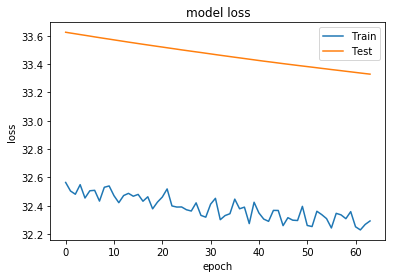

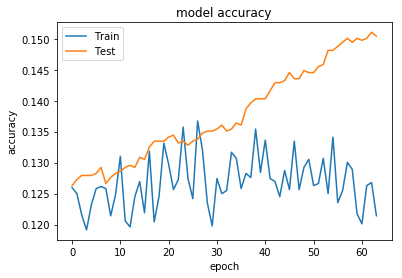

In [13]:
################################################################################
plt.plot(histories.history['loss'])
plt.plot(histories.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.plot(histories.history['acc'])
plt.plot(histories.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [14]:
################################################################################
test_input  = val_data
test_output = val_output
predictions = model.predict(test_input)
print("\nAvg Difference: {}".format(np.abs(test_output - predictions).mean()))
print("=== Input ===\n{}".format(test_input))
print("\n=== True Output ===\n{}".format(test_output))
print("\n=== Prediction ===\n{}".format(predictions))


Avg Difference: 0.21845018490481985
=== Input ===
[[[7 0 5]
  [7 5 0]
  [0 2 3]
  [0 3 1]
  [8 8 8]
  [4 4 7]]

 [[0 3 5]
  [0 4 3]
  [1 8 5]
  [6 2 4]
  [3 6 2]
  [2 3 8]]

 [[7 4 2]
  [4 1 6]
  [2 3 4]
  [6 5 5]
  [8 6 4]
  [2 3 1]]

 [[8 0 1]
  [8 0 5]
  [8 6 7]
  [2 0 2]
  [2 1 8]
  [7 3 0]]

 [[6 5 1]
  [7 4 8]
  [7 1 0]
  [8 6 8]
  [0 5 4]
  [5 3 4]]

 [[2 1 6]
  [6 8 6]
  [7 3 7]
  [4 8 1]
  [3 0 2]
  [6 2 7]]

 [[6 0 7]
  [8 1 6]
  [6 4 5]
  [8 6 2]
  [4 4 2]
  [8 2 2]]

 [[3 2 3]
  [5 4 2]
  [2 4 5]
  [7 2 6]
  [5 1 6]
  [3 5 7]]

 [[3 5 6]
  [2 5 6]
  [3 1 6]
  [4 5 5]
  [4 8 4]
  [6 4 6]]

 [[8 6 8]
  [2 6 8]
  [1 6 0]
  [4 5 1]
  [6 1 2]
  [7 3 4]]

 [[2 4 2]
  [0 7 5]
  [5 8 4]
  [3 8 3]
  [7 7 4]
  [1 1 7]]

 [[5 7 7]
  [4 8 5]
  [6 4 1]
  [7 0 0]
  [6 7 8]
  [5 1 0]]

 [[5 3 0]
  [3 8 3]
  [8 7 7]
  [8 3 7]
  [0 2 2]
  [8 1 8]]

 [[0 6 4]
  [1 3 5]
  [1 2 3]
  [1 5 6]
  [7 2 0]
  [6 0 4]]

 [[2 1 4]
  [8 8 1]
  [6 2 4]
  [0 6 3]
  [3 3 0]
  [7 8 6]]

 [[1 4 0]
  [1 0 7]